In [40]:
import numpy as np
import pickle
from easydict import EasyDict as edict
from tqdm.autonotebook import tqdm

In [2]:
from tmpUtils import *

In [4]:
with open("../data/realmat.pkl", "rb") as f:
        real = pickle.load(f)

In [5]:
Y = real.Y
X = real.X
U = real.U

In [6]:
R = 6
dF = 5
dT = 100
invU = np.linalg.inv(real.U)
pUinv = invU[:R, :]
rawX = real.X[:, :dF, :dT] # d x dF x dT
pRawX = np.transpose(rawX,(1, 2, 0))# dF x dT x d
X = np.matmul(pRawX,pUinv.T)


In [49]:
ChgsFreq = [2]
ChgsT = [50]
eigIndAll = real.eigVs.imag != 0
ChgsTF = np.concatenate([[0], ChgsT, [dT]])
ChgsFreqF = np.concatenate([[0], ChgsFreq, [dF]])

In [50]:
Mus = GenFVecs(R, eigIndAll[:R], ChgsFreqF)
Nus = GenFVecs(R, eigIndAll[:R], ChgsTF)
stdMus =  Mus /np.linalg.norm(Mus, axis=1).reshape(-1, 1)

In [51]:
Y = np.zeros_like(X)
for df in range(dF):
    for dt in range(dT):
        cX = X[df, dt, :]
        cMu = stdMus[:, df]
        cNu = Nus[:, dt]
        pEigVs =cMu * cNu
        cY = cX * pEigVs 
        Y[df, dt, :] = cY
 

In [52]:
Mus = np.transpose(Mus,(1,0))
Nus = np.transpose(Nus,(1,0))
stdMus = np.transpose(stdMus,(1,0))

In [53]:
tMus =  np.concatenate([Mus.real,Mus.imag],1)
tNus =  np.concatenate([Nus.real,Nus.imag],1)
tdMus =  np.concatenate([stdMus.real,stdMus.imag],1)

In [54]:
def update_X(lambda_,X, dim):
    H,W,_ = np.shape(X)
    X_tilde = np.zeros_like(X)
    if dim == 0:
        for i in range(W):
            X_tilde[:,i]=X[:,i]*lambda_
    else:
        for i in range(H):
            X_tilde[i]=X[i]*lambda_
    return X_tilde
    

In [72]:
def threshold(x,lamb):
    x = np.sign(x)*np.maximum(abs(x)-lamb,0)
    return x

def grad_x(x):
    g = x[1:,:]-x[:-1,:]
    return g
    
def grad_xT(x):
    H,W = np.shape(x)
    div = np.zeros([H+1,W])
    div[1:,:] = x
    div[0:-1,:] +=   - x
    return div
    
    
def CG(A,b,x0,ep):
    r = b - A(x0)
    p = r 
    x = x0
    rsold = np.sum(r*r)
    eps = ep*np.sqrt(rsold)
    for i in range(1000):
        ap = A(p)
        alpha = rsold/np.sum(p*ap)
        x += alpha*p
        r -= alpha*ap
        rsnew = np.sum(r*r)
        if np.sqrt(rsnew) < eps:
            break
        p = r + (rsnew/rsold)*p
        rsold = rsnew
    return x

def generate_f(X,rho,dim):
    H,W,_ = np.shape(X)
    A = np.sum(X*np.conjugate(X),dim)/H/W
    
    def f(x):
        u,v = np.split(x,2,1)
        y = np.concatenate([A.real*u-A.imag*v,A.real*v+A.imag*u],1)
        y += rho*grad_xT(grad_x(x))
        return y 
    return f

def normalize(u):
    x, y = np.split(u,2,1)
    d = np.sqrt(np.sum(x**2+y**2,0))
    return np.concatenate([x/d,y/d],1)

def iner_solve(Y,X,u,dim, option,is_normal = False):
   
    rho = option['rho']
    eps = option['eps']
    T_max = option['T']
    lamb = option['lamb']
    
    #dmu,dnv,d = np.shape(Y)
   
    d = grad_x(u)
    b = np.zeros_like(d)
    
    delta = 1.618
    f_norm = np.sqrt(np.sum(Y*np.conjugate(Y)))*eps
    
    W,H,_ = np.shape(X)
    ATf = np.sum(np.conjugate(X)*Y,dim)/W/H
    ATf = np.concatenate([ATf.real,ATf.imag],1)
    func = generate_f(X,rho,dim)
    for i in range(T_max): 
        if is_normal:
            u = CG(func,ATf+rho*grad_xT(d-b),u,eps)
            
        else:
            u = CG(func,ATf+rho*grad_xT(d-b),u,eps)
        g = grad_x(u)
        d = threshold (g + b,lamb/rho)
        err = g - d
        if np.sqrt(np.sum(err**2))<f_norm:
            break
        b += delta *err 
    return u
    

In [82]:
def out_iter(X,Y,lamb,Mus,Nus):
    H,W,d = np.shape(X)
    eMus = tdMus + np.random.randn(H,2*d)
    eNus = tNus + np.random.randn(W,2*d)
    options1 = {'lamb':lamb/10,'T':10,'rho':1.,'eps':1e-6}
    options2 = {'lamb':lamb/20,'T':10,'rho':1.,'eps':1e-7,'tau':1e-6}
    pbar = tqdm(range(30))
    for i in pbar:
        # if i == 0:
        #     pbar.set_description(f"Outer Loop: The chdiff is {chDiffBoth.item():.3e}.")
        eMus_1,eMus_2= np.split(eMus,2,1)
        eMus_c = eMus_1+eMus_2*1j
        X_tilde  = update_X(eMus_c,X, dim=0)
        eNus = iner_solve(Y,X_tilde,eNus,0, options1)
         
        eNus_1,eNus_2= np.split(eNus,2,1)
        eNus_c = eNus_1+eNus_2*1j
        X_tilde  = update_X(eNus_c,X, dim=1)
        eMus = iner_solve(Y,X_tilde,eMus,1, options2,is_normal=True)
        eMus = normalize(eMus)
        # print(np.sqrt(np.sum(abs(eMus_c-Mus)**2))/np.sqrt(np.sum(abs(Mus)**2)))
        # print(np.sqrt(np.sum(abs(eNus_c-Nus)**2))/np.sqrt(np.sum(abs(Nus)**2)))
    return eNus,eMus,eNus_c,eMus_c

In [83]:
eNus,eMus,eNus_c,eMus_c = out_iter(X,Y,1.,stdMus,Nus)
np.sqrt(np.sum(abs(eMus-tdMus)**2))/np.sqrt(np.sum(abs(tdMus)**2))

  0%|          | 0/30 [00:00<?, ?it/s]

1.1808437170877468

In [84]:
np.sqrt(np.sum(abs(eNus-tNus)**2))/np.sqrt(np.sum(abs(tNus)**2))

1.2644837376491895

In [85]:
np.sqrt(np.sum(abs(eNus-tNus)**2))/np.sqrt(np.sum(abs(tNus)**2))

1.2644837376491895

In [86]:
def eval_fun(Y,X,eNus,eMus,lamb1,lamb2):
    eMus_1,eMus_2= np.split(eMus,2,1)
    eMus_c = eMus_1+eMus_2*1j
    eNus_1,eNus_2= np.split(eNus,2,1)
    eNus_c = eNus_1+eNus_2*1j
    X_tilde  = update_X(eNus_c,X, dim=1)
    X_tt  = update_X(eMus_c,X_tilde, dim=0)
    H, W, d = np.shape(X)
    return np.sum((abs(Y-X_tt))**2)/H/W,lamb1*np.sum(abs(grad_x(eMus))),lamb2*np.sum(abs(grad_x(eNus))),np.sum((abs(Y-X_tt))**2)/H/W+lamb1*np.sum(abs(grad_x(eMus)))+lamb2*np.sum(abs(grad_x(eNus)))
    

In [87]:
print(eval_fun(Y,X,tNus,tdMus,0.1,0.05))
#print(eval_fun(Y,X,tNus,tdMus,0.01))
print(eval_fun(Y,X,eNus,eMus,0.1,0.05))
#print(eval_fun(Y,X,eNus,eMus,0.01))

(6.856213948111624e-25, 0.19010368882008893, 1.5, 1.6901036888200889)
(18.44768952199583, 0.18594624043260896, 1.607742335536219, 20.24137809796466)


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

([], [])

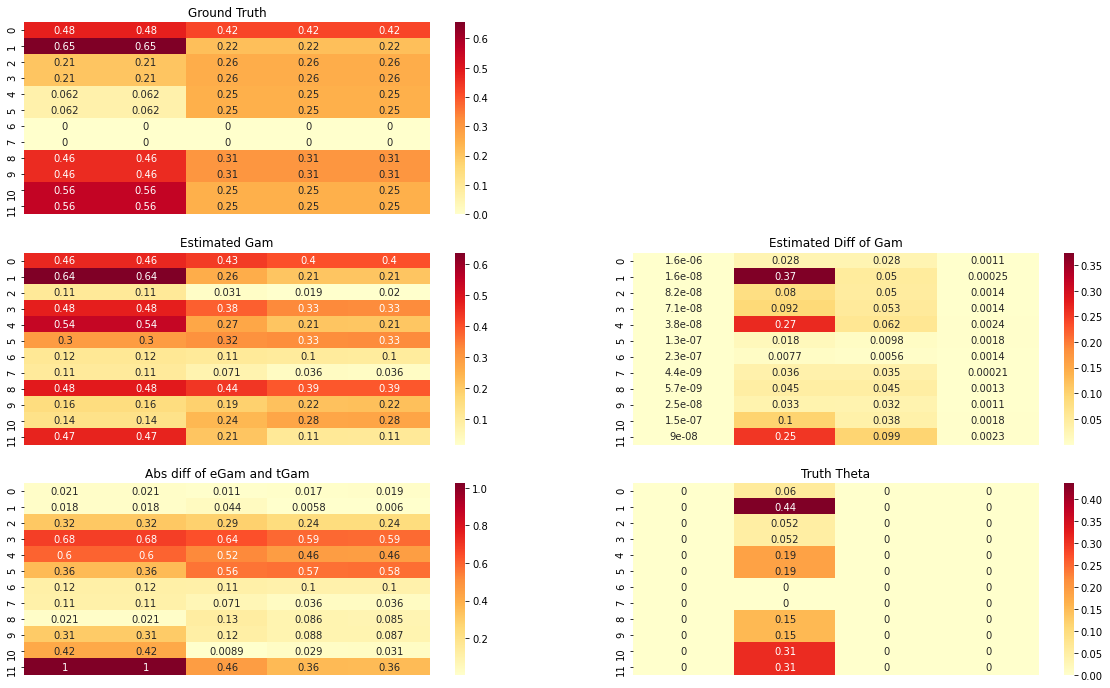

In [89]:
tdMusPlot = tdMus.T
eMusPlot = eMus.T
eDiffMus = np.diff(eMus, axis=0).T


plt.figure(figsize=[20, 12])

is_annot = True
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tdMusPlot), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eMusPlot), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(tdMusPlot-eMusPlot), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

# plt.subplot(322)
# plt.title("Estimated Theta")
# sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
# plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tdMusPlot, axis=1)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

([], [])

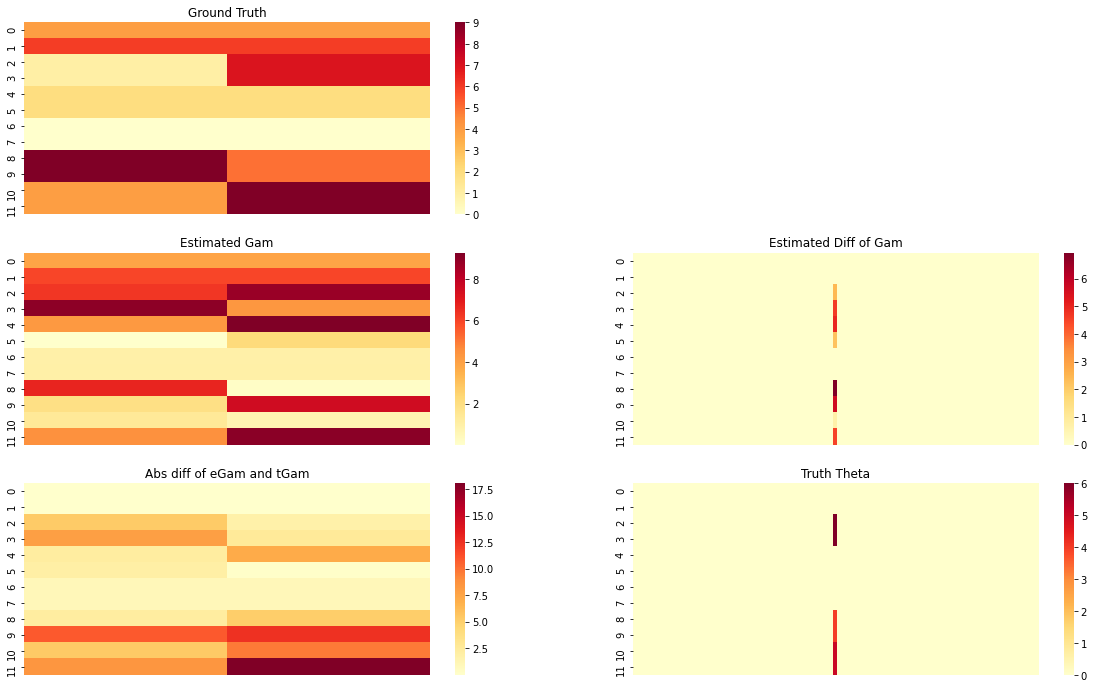

In [90]:
tNusPlot = tNus.T
eNusPlot = eNus.T
eDiffNus = np.diff(eNus, axis=0).T


plt.figure(figsize=[20, 12])

is_annot = False
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tNusPlot), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eNusPlot), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(tNusPlot-eNusPlot), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

# plt.subplot(322)
# plt.title("Estimated Theta")
# sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
# plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tNusPlot, axis=1)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

In [713]:
def generate_f2(X,dim):
    A = np.mean(X*np.conjugate(X),dim)
    
    def f(x):
        u,v = np.split(x,2,1)
        y = np.concatenate([A.real*u-A.imag*v,A.real*v+A.imag*u],1)
        return y 
    return f

In [976]:
X_tilde  = update_X(Nus,X, dim=1)
u =  np.random.randn(H,2*d)
func = generate_f2(X_tilde,1)
b = np.mean(np.conjugate(X_tilde)*Y,1)
b = np.concatenate([b.real,b.imag],1)
u = CG(func,b,u,1e-14)
#u = CG(func,b,u,1e-9)
print(np.sqrt(np.sum(abs(u-tdMus)**2))/np.sqrt(np.sum(abs(tdMus)**2)))

3.820445327767638e-10


In [784]:
X_tilde  = update_X(stdMus,X, dim=0)
u =  np.random.randn(W,2*d)
func = generate_f2(X_tilde,0)
b = np.mean(np.conjugate(X_tilde)*Y,0)
b = np.concatenate([b.real,b.imag],1)
u = CG(func,b,u,1e-10)

print(np.sqrt(np.sum(abs(u-tNus)**2))/np.sqrt(np.sum(abs(tNus)**2)))

4.904297163796922e-09


In [979]:
func(tdMus)-b

array([[ 2.98023224e-08, -4.47034836e-08, -7.45058060e-09,
         1.11758709e-08,  1.86264515e-08,  1.86264515e-08,
        -7.01697314e-23, -7.44557074e-23, -7.45058060e-09,
        -1.11758709e-08, -7.45058060e-09, -1.86264515e-09],
       [ 3.72529030e-09, -7.45058060e-08, -9.31322575e-10,
         2.32830644e-09,  6.51925802e-09,  1.86264515e-09,
        -3.98460656e-23,  2.28632721e-23,  9.31322575e-10,
        -9.31322575e-10,  4.65661287e-09, -9.31322575e-10],
       [ 3.52365706e-19, -1.73472348e-18,  2.71050543e-20,
         5.42101086e-20, -2.16840434e-19, -1.62630326e-19,
         7.07779255e-35, -1.64185528e-34,  5.42101086e-20,
        -1.62630326e-19, -1.62630326e-19,  1.08420217e-19],
       [-8.52651283e-14, -4.54747351e-13, -1.77635684e-15,
         3.55271368e-15, -1.77635684e-14, -1.06581410e-14,
        -1.51668076e-27,  9.56386063e-28,  1.77635684e-14,
        -1.42108547e-14, -7.10542736e-15,  3.55271368e-15],
       [-1.16415322e-10,  5.82076609e-10, -7.2759576

In [904]:
nu=normalize(tdMus)-tdMus

In [906]:
nu

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.55111512e-17,  5.55111512e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.55111512e-17, -5.55111512e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.55111512e-17,  5.55111512e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.55111512e-17, -5.55111512e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.55111512e-17,  5.55111512e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.55111512e-17, -5.55111512e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.55111512e-17,  5.55111512e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.55111512e-17, -5.55111512e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.0000000

In [876]:
nu

array([[ 0.12403473,  0.6       ,  0.6401844 ,  0.6401844 ,  0.62469505,
         0.62469505,         nan,         nan,  0.26764386, -0.26764386,
         0.5547002 , -0.5547002 ],
       [ 0.49613894,  0.4       ,  0.38411064,  0.38411064,  0.3904344 ,
         0.3904344 ,         nan,         nan,  0.48175895, -0.48175895,
         0.41602515, -0.41602515],
       [ 0.49613894,  0.4       ,  0.38411064,  0.38411064,  0.3904344 ,
         0.3904344 ,         nan,         nan,  0.48175895, -0.48175895,
         0.41602515, -0.41602515],
       [ 0.49613894,  0.4       ,  0.38411064,  0.38411064,  0.3904344 ,
         0.3904344 ,         nan,         nan,  0.48175895, -0.48175895,
         0.41602515, -0.41602515],
       [ 0.49613894,  0.4       ,  0.38411064,  0.38411064,  0.3904344 ,
         0.3904344 ,         nan,         nan,  0.48175895, -0.48175895,
         0.41602515, -0.41602515]])